In [1]:
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy

from kan import *

import sys
sys.path.append('../utils')
from base import *


torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
class FKAN(KAN):
    def __init__(self, in_func, out_func, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.in_func = in_func
        self.out_func = out_func 
    
    # def update_grid(self, x):
    #     '''
    #     call update_grid_from_samples. This seems unnecessary but we retain it for the sake of classes that might inherit from MultKAN
    #     '''
    #     x = x.detach().numpy()
    #     self.update_grid_from_samples(x)


    def forward(self, x, singularity_avoiding=False, y_th=10.):
        x = points_to_curve_2d(x)
        # print(x.shape)

        x = x[:,self.input_id.long()]
        assert x.shape[1] == self.width_in[0]
        # print(x.shape[1], self.width_in)
        
        # cache data
        self.cache_data = x
        
        self.acts = []  # shape ([batch, n0], [batch, n1], ..., [batch, n_L])
        self.acts_premult = []
        self.spline_preacts = []
        self.spline_postsplines = []
        self.spline_postacts = []
        self.acts_scale = []
        self.acts_scale_spline = []
        self.subnode_actscale = []
        self.edge_actscale = []
        # self.neurons_scale = []

        self.acts.append(x)  # acts shape: (batch, width[l])

        for l in range(self.depth):
            
            x_numerical, preacts, postacts_numerical, postspline = self.act_fun[l](x)
            #print(preacts, postacts_numerical, postspline)
            
            if self.symbolic_enabled == True:
                x_symbolic, postacts_symbolic = self.symbolic_fun[l](x, singularity_avoiding=singularity_avoiding, y_th=y_th)
            else:
                x_symbolic = 0.
                postacts_symbolic = 0.

            x = x_numerical + x_symbolic
            
            if self.save_act:
                # save subnode_scale
                self.subnode_actscale.append(torch.std(x, dim=0).detach())
            
            # subnode affine transform
            x = self.subnode_scale[l][None,:] * x + self.subnode_bias[l][None,:]
            
            if self.save_act:
                postacts = postacts_numerical + postacts_symbolic

                # self.neurons_scale.append(torch.mean(torch.abs(x), dim=0))
                #grid_reshape = self.act_fun[l].grid.reshape(self.width_out[l + 1], self.width_in[l], -1)
                input_range = torch.std(preacts, dim=0) + 0.1
                output_range_spline = torch.std(postacts_numerical, dim=0) # for training, only penalize the spline part
                output_range = torch.std(postacts, dim=0) # for visualization, include the contribution from both spline + symbolic
                # save edge_scale
                self.edge_actscale.append(output_range)
                
                self.acts_scale.append((output_range / input_range).detach())
                self.acts_scale_spline.append(output_range_spline / input_range)
                self.spline_preacts.append(preacts.detach())
                self.spline_postacts.append(postacts.detach())
                self.spline_postsplines.append(postspline.detach())

                self.acts_premult.append(x.detach())
            
            # multiplication
            dim_sum = self.width[l+1][0]
            dim_mult = self.width[l+1][1]
            
            if self.mult_homo == True:
                for i in range(self.mult_arity-1):
                    if i == 0:
                        x_mult = x[:,dim_sum::self.mult_arity] * x[:,dim_sum+1::self.mult_arity]
                    else:
                        x_mult = x_mult * x[:,dim_sum+i+1::self.mult_arity]
                        
            else:
                for j in range(dim_mult):
                    acml_id = dim_sum + np.sum(self.mult_arity[l+1][:j])
                    for i in range(self.mult_arity[l+1][j]-1):
                        if i == 0:
                            x_mult_j = x[:,[acml_id]] * x[:,[acml_id+1]]
                        else:
                            x_mult_j = x_mult_j * x[:,[acml_id+i+1]]
                            
                    if j == 0:
                        x_mult = x_mult_j
                    else:
                        x_mult = torch.cat([x_mult, x_mult_j], dim=1)
                
            if self.width[l+1][1] > 0:
                x = torch.cat([x[:,:dim_sum], x_mult], dim=1)
            
            # x = x + self.biases[l].weight
            # node affine transform
            x = self.node_scale[l][None,:] * x + self.node_bias[l][None,:]
            
            self.acts.append(x.detach())
        # print(x)
        x = nss_2d(arr=x)    
        # x = spline_curve_to_points_2d(arr=x)        
        return x

# model = FKAN(in_func=1, out_func=2, width=[2,5,1], grid=5, k=3, seed=0, auto_save=False)


In [3]:
df = treasury_data_retrieval('us_treasury_rates_large.csv').head()

dtype = torch.get_default_dtype()

points_to_curve_2d(df.values)

tensor([[2.3894, 2.4568, 2.7025, 2.4719, 2.4394, 2.7923, 2.8368, 2.9696],
        [2.4128, 2.4333, 2.5666, 2.3720, 2.3085, 2.7087, 2.7519, 2.9195],
        [2.3942, 2.4775, 2.6361, 2.4895, 2.4303, 2.8253, 2.8137, 2.9796],
        [2.4048, 2.5211, 2.6265, 2.5251, 2.4753, 2.8435, 2.8576, 2.9896],
        [2.3924, 2.5376, 2.6320, 2.5856, 2.5348, 2.8330, 2.8979, 2.9995]])

In [4]:
df_x2 = pd.concat([df, df, df], axis=1)
ts_x2 = points_to_curve_2d(df_x2.values)

np.savetxt("tensor.txt", ts_x2.numpy(), fmt="%.5f")
ts_x2

tensor([[2.3894, 2.4568, 2.7025, 2.4719, 2.4394, 2.7923, 2.8368, 2.9696, 2.3894,
         2.4568, 2.7025, 2.4719, 2.4394, 2.7923, 2.8368, 2.9696, 2.3894, 2.4568,
         2.7025, 2.4719, 2.4394, 2.7923, 2.8368, 2.9696],
        [2.4128, 2.4333, 2.5666, 2.3720, 2.3085, 2.7087, 2.7519, 2.9195, 2.4128,
         2.4333, 2.5666, 2.3720, 2.3085, 2.7087, 2.7519, 2.9195, 2.4128, 2.4333,
         2.5666, 2.3720, 2.3085, 2.7087, 2.7519, 2.9195],
        [2.3942, 2.4775, 2.6361, 2.4895, 2.4303, 2.8253, 2.8137, 2.9796, 2.3942,
         2.4775, 2.6361, 2.4895, 2.4303, 2.8253, 2.8137, 2.9796, 2.3942, 2.4775,
         2.6361, 2.4895, 2.4303, 2.8253, 2.8137, 2.9796],
        [2.4048, 2.5211, 2.6265, 2.5251, 2.4753, 2.8435, 2.8576, 2.9896, 2.4048,
         2.5211, 2.6265, 2.5251, 2.4753, 2.8435, 2.8576, 2.9896, 2.4048, 2.5211,
         2.6265, 2.5251, 2.4753, 2.8435, 2.8576, 2.9896],
        [2.3924, 2.5376, 2.6320, 2.5856, 2.5348, 2.8330, 2.8979, 2.9995, 2.3924,
         2.5376, 2.6320, 2.5856, 2.5348

In [5]:
df = pd.DataFrame({
    'beta_0': [1, 2, 3, 4],
    'beta_1': [2, 3, 4, 1],
    'beta_2': [3, 1, 2, 4],
    'beta_3': [0.5, 0.7, 0.1, 0.2]
})
nss_2d(df.values)

tensor([[3.0197, 3.0372, 3.0526, 3.0876, 3.1151, 3.0570, 2.9202, 2.5896, 2.2948,
         1.9730, 1.4998, 1.3333],
        [4.9422, 4.8856, 4.8301, 4.6703, 4.3801, 3.9060, 3.5491, 3.0781, 2.8028,
         2.5700, 2.2857, 2.1905],
        [6.9917, 6.9833, 6.9750, 6.9500, 6.9001, 6.8006, 6.7020, 6.5086, 6.3218,
         6.0570, 5.3233, 4.8009],
        [5.0247, 5.0487, 5.0721, 5.1388, 5.2568, 5.4397, 5.5647, 5.6891, 5.7043,
         5.6203, 5.1538, 4.8214]], dtype=torch.float32)

In [9]:
df = pd.DataFrame({
    'beta_0': [1, 2, 3, 4],
    'beta_1': [2, 3, 4, 1],
    'beta_2': [3, 1, 2, 4],
    'beta_3': [0.5, 0.7, 0.1, 0.2],
    'beta_4': [1, 2, 3, 4],
    'beta_5': [1, 2, 3, 4],
    'beta_6': [1, 2, 3, 4],
    'beta_7': [1, 2, 3, 4]
})
spline_curve_to_points_2d(df.values)
# df.values
# spline_curve_to_points([1, 2, 3, 4], x = torch.tensor([1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]), 
#         t = [1, 2, 3, 5], 
#         k = 3)

tensor([[1.0000, 1.2597, 1.4932, 2.0325, 2.3520, 0.9911, 0.8333, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000],
        [2.0000, 2.2260, 2.3657, 2.3734, 1.4993, 0.9139, 1.5667, 2.0000, 2.0000,
         2.0000, 2.0000, 2.0000],
        [3.0000, 3.2258, 3.3642, 3.3508, 2.2588, 0.7882, 2.0333, 3.0000, 3.0000,
         3.0000, 3.0000, 3.0000],
        [4.0000, 3.2875, 2.7692, 2.1233, 2.6122, 1.3264, 2.7333, 4.0000, 4.0000,
         4.0000, 4.0000, 4.0000]])

In [11]:
df = treasury_data_retrieval('us_treasury_rates_large.csv')
data, ori_col = full_df_retrieval(df)
all_cols = data.columns
data.tail()

,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,...,3 Mo_-_1_window_5,6 Mo_-_1_window_5,1 Yr_-_1_window_5,2 Yr_-_1_window_5,3 Yr_-_1_window_5,5 Yr_-_1_window_5,7 Yr_-_1_window_5,10 Yr_-_1_window_5,20 Yr_-_1_window_5,30 Yr_-_1_window_5
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-02,4.75,4.63,4.51,4.43,4.30,4.17,4.11,4.08,4.13,4.19,...,4.608,4.444,4.360,4.222,4.202,4.160,4.214,4.282,4.546,4.466
2024-12-03,4.66,4.56,4.49,4.40,4.27,4.17,4.13,4.11,4.17,4.23,...,4.584,4.438,4.336,4.182,4.160,4.116,4.170,4.238,4.504,4.418
2024-12-04,4.65,4.54,4.47,4.38,4.23,4.13,4.09,4.07,4.13,4.19,...,4.558,4.426,4.316,4.174,4.144,4.104,4.162,4.230,4.498,4.408
2024-12-05,4.59,4.53,4.46,4.38,4.23,4.15,4.10,4.07,4.12,4.17,...,4.530,4.412,4.288,4.158,4.120,4.084,4.140,4.208,4.476,4.382
2024-12-06,4.57,4.50,4.42,4.34,4.19,4.10,4.05,4.03,4.09,4.15,...,4.502,4.402,4.266,4.150,4.106,4.076,4.130,4.192,4.458,4.360


In [37]:
# Out-of-sample test size, diff between sliding element = test size
test_size = 1
sliding_list = range(1, 0, -1)

# Set variables for cross-validation
truth_df = pd.DataFrame()
naive_df = pd.DataFrame()
kan_df = pd.DataFrame()

# Loop over sliding windows
for sliding in sliding_list:
    
    # Trim original data by sliding window size
    df = data[:len(data)-sliding]

    # Use 2 years of data (500 days) for training
    df_train, df_test = df[-test_size-60:-test_size], df[-test_size:]
    len_train = len(df_train)

    # Append to truth dataframe, if multi-step drop iloc
    truth_df = pd.concat([truth_df, df_test[ori_col].iloc[[-1], :]], axis=0, ignore_index=False)

    # Append to naive dataframe, if multi-step change 1 to test_size
    naive_element = pd.DataFrame([df_train[ori_col].iloc[-1].values] * 1)
    naive_df = pd.concat([naive_df, naive_element], axis=0, ignore_index=True)

    # Initialize predictions array
    pred = list()

    # To predict multi-step use range, to predict only h-ahead-step use equal
    # for h in range(test_size):
    for h in [test_size - 1]:
        # Print checkpoints
        print(f'LAST DAY OF DATASET: {-sliding}, FUTURE STEPS: {h+1}')

        # If h = 0 target columns unchanged
        if h == 0:  
            target_col = ori_col
        # If h > 0 target columns modified
        else:       
            target_col = [f'{element}_+_{h}' for element in ori_col]
        
        # Extract feature columns
        feature_col = [element for element in all_cols if 'window' in element]

        # Cut train data due to direct forecast
        df_train_modified = df_train[:(len_train-h)]

        # Test data is the first row 
        df_test_modified = df_test.iloc[[0]]
        print(len(df_train_modified))

        X_train, y_train = df_train_modified[feature_col], df_train_modified[target_col]
        X_test, y_test = df_test_modified[feature_col], df_test.iloc[h][ori_col]

        X_concat = pd.concat([X_train, X_test], axis=0)

        n_inputs = X_train.shape[1]
        n_outputs = y_train.shape[1]

        dataset = dict()
        dtype = torch.get_default_dtype()
        dataset['train_input'] = torch.from_numpy(X_train.values).type(dtype).to(device)
        dataset['train_label'] = torch.from_numpy(y_train.values).type(dtype).to(device)
        dataset['test_input'] = torch.from_numpy(X_test.values).type(dtype).to(device)
        dataset['test_label'] = torch.from_numpy(y_test.values).type(dtype).to(device)

        # Initialize the model
        model = FKAN(width=[24, 6, 8, 4], grid=4, k=3, seed=42, device=device, symbolic_enabled=False, save_act=True, auto_save=False, in_func=None, out_func=None)

        # Train the model and compute metrics
        results = model.fit(dataset, opt="Adam", lr=0.05, steps=2000, update_grid=True)

        # loss_fn = loss_fn_eval = lambda x, y: torch.mean((x - y) ** 2)
        # p = 
        # train_loss = loss_fn(p, dataset['train_label'])
        # print(train_loss)
        # torch.sqrt(train_loss).cpu().detach().numpy()


        pred.append(model.forward(dataset['test_input']).cpu().detach().numpy().flatten())
        # print(n_inputs, n_outputs)

    kan_element = pd.DataFrame(pred)
    kan_df = pd.concat([kan_element, kan_df], axis=0, ignore_index=True)

# df_train_modified
# df_test_modified
# y_train
# X_test
# model(dataset['test_input'])

LAST DAY OF DATASET: -1, FUTURE STEPS: 1
60


| train_loss: 9.29e-02 | test_loss: 3.98e-01 | reg: 6.86e+01 | : 100%|█| 2000/2000 [01:57<00:00, 16.


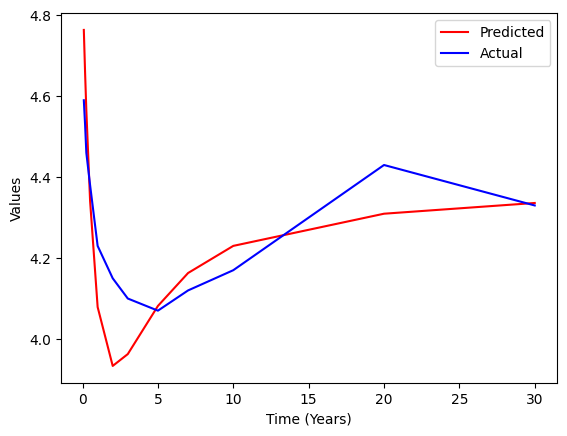

In [38]:
y_pred = model(dataset['test_input']).cpu().detach().numpy().flatten()
y_test = dataset['test_label'].cpu().detach().numpy().flatten()

import matplotlib.pyplot as plt

x_values = [1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]

plt.plot(x_values, y_pred, color='red', label="Predicted")
plt.plot(x_values, y_test, color='blue', label="Actual")

plt.xlabel("Time (Years)")
plt.ylabel("Values")
plt.legend()
plt.show()

